# Prepare data frame with AGB from ATL08 height in boreal
### boreal ATL08 AGB
Paul Montesano, March 2023  
#### Workspace used: `mas.maap-project.org/root/maap-workspaces/jupyterlab3/r:v3.1.3`
#### Memory: `64Gi`  
#### Packages needed installed on top of base R 
`conda install -c conda-forge r-rnaturalearth r-rnaturalearthdata r-mapproj r-rgeos r-viridis r-wesanderson r-patchwork r-aws.s3 r-feather r-rockchalk`

In [1]:
library(aws.s3)
library(rgdal)
library(raster)
library(tidyverse)
library(dplyr)
library(grid)
library(gridExtra)
library(RColorBrewer)
library(data.table)

library(fs)
library(sf)

library(rgeos)
library(mapproj)
#library(rgee)
library(viridis)
library(wesanderson)
library(scales)
library(tools)
library(patchwork)

library(rnaturalearth)
library(rnaturalearthdata)
library(feather)
library(tools)
library(rockchalk)

Loading required package: sp

Please note that rgdal will be retired by the end of 2023,
plan transition to sf/stars/terra functions using GDAL and PROJ
at your earliest convenience.

rgdal: version: 1.5-32, (SVN revision 1176)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.6.2, released 2023/01/02
Path to GDAL shared files: /opt/conda/share/gdal
 GDAL does not use iconv for recoding strings.
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 9.1.0, September 1st, 2022, [PJ_VERSION: 910]
Path to PROJ shared files: /projects/.local/share/proj:/opt/conda/share/proj
PROJ CDN enabled: TRUE
Linking to sp version:1.5-1
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading sp or rgdal.

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ g

In [2]:
OUTDIR = '/projects/my-public-bucket/boreal_ATL08_AGB'

In [3]:
ATL08_tindex_fn = 's3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/ATL08_tindex_master.csv'

## Set output figure dir.

In [4]:
OUT_FIGURE_DIR = '/projects/my-public-bucket/boreal_polar_map/paper_figs'

### AGB Calc Function

In [5]:
GEDI2AT08AGB_v2 <- function(rds_models, models_id, in_data, offset=100, 
                            COLS_LIST= c("lon","lat","RH_25","RH_50","RH_60","RH_70","RH_75","RH_80","RH_90","RH_95","RH_98"), 
                            EXCLUDE_LC_VALUE_LIST = c(0, 60, 80, 200, 50, 70), # Updated with copernicus LC values for which we want to assign AGB values of 0 
                            DO_MASK=FALSE, 
                            RESAMP_COVAR_MAT=TRUE, 
                            RESAMP_ITER=50
                           ){
    #'''
    # Function to compute mean AGB and SE from ICESat-2 ATL08 observations of vegetation height.
    # Uses the GEDI-developed allometric equations (2 parameters of RH values)
    #
    # This version works the same as the original function GEDI2AT08AGB() used in Phase 2 work, with a few minor updates to usability
    # v2 updates:
    # Returns: a 3 col table (AGB model id, AGB, AGB SE)
    # Added args for added flexiblity: 
    #       COLS_LIST, EXCLUDE_LC_VALUE_LIST
    #       RESAMP_COVAR_MAT --> boolean to handle resampling covar matrix
    #'
    
    # rds_models
    #names(rds_models)<-models_id

    #if(DO_MASK){
    #    in_data = in_data %>% dplyr::filter(slopemask ==1 & ValidMask == 1)
    #}
    xtable_i<-na.omit(as.data.frame(in_data))
    names(xtable_i)[1:length(COLS_LIST)]<-COLS_LIST  # PMM names(xtable_i)[1:11]<-COLS_LIST

    # Adjust for offset in model fits (100)
    # GEDI L4A team added offset to all the height metrics so they would never be negative)
    #xtable_sqrt<-xtable_i[3:10]+offset
    xtable_sqrt <- xtable_i %>% dplyr::select(contains("RH")) + offset # PMM 

    # get unique ids
    # apply models by id
    xtable_sqrt$AGB<-NA
    xtable_sqrt$SE<-NA
    
    # Assign model id based on landcover

    # if using ground photon models: 1 = DBT trees (boreal-wide), 2=Evergreen needleleaf trees (boreal-wide), 12 = boreal-wide all PFT
    # if using no ground photon models: 1 = DBT trees (boreal-wide), 3=Evergreen needleleaf trees (boreal-wide), 8 = boreal-wide all PFT

    # for the seg_landcov: {0: "water", 1: "evergreen needleleaf forest", 2: "evergreen broadleaf forest", \ 3: "deciduous needleleaf forest", 4: "deciduous broadleaf forest", \ 5: "mixed forest", 6: "closed shrublands", 7: "open shrublands", \ 8: "woody savannas", 9: "savannas", 10: "grasslands", 11: "permanent wetlands", \ 12: "croplands", 13: "urban-built", 14: "croplands-natural mosaic", \ 15: "permanent snow-ice", 16: "barren"})
    
    # for the seg_landcov update w v5 to Copernicus: 
    # {0: "NA", 111, 121: "evergreen needleleaf forest", 112, 122: "evergreen broadleaf forest", \ 
    # 113, 123: "deciduous needleleaf forest", 114, 124: "deciduous broadleaf forest", \ 
    # 115, 125: "mixed forest", 116, 126:"closed forest unknown", 20: "shrublands", 30: "herbaceous vegetation", \ 
    # 100: "moss and lichen", 60: "bare/sparse", 80, 200: "water", 40: "agriculture", 50: "urban-built", 70: "permanent snow-ice"})

    xtable_sqrt$model_id <- 'NA'
    xtable_sqrt$model_id[xtable_i$seg_landcov==111] <- 'ENT_coarse_1.rds'#'m3'
    xtable_sqrt$model_id[xtable_i$seg_landcov==121] <- 'ENT_coarse_1.rds'#'m3'
    xtable_sqrt$model_id[xtable_i$seg_landcov==112] <- 'DBT_coarse_2.rds'#'m1'
    xtable_sqrt$model_id[xtable_i$seg_landcov==122] <- 'DBT_coarse_2.rds'#'m1
    xtable_sqrt$model_id[xtable_i$seg_landcov==113] <- 'ENT_coarse_1.rds'#'m3'
    xtable_sqrt$model_id[xtable_i$seg_landcov==123] <- 'ENT_coarse_1.rds'#'m3'
    xtable_sqrt$model_id[xtable_i$seg_landcov==114] <- 'DBT_coarse_2.rds'#'m1
    xtable_sqrt$model_id[xtable_i$seg_landcov==124] <- 'DBT_coarse_2.rds'#'m1
    xtable_sqrt$model_id[xtable_sqrt$model_id=='NA'] <- 'world_coarse_2.rds'#'m8
    
#     xtable_sqrt$model_id <- 'NA'
#     xtable_sqrt$model_id[xtable_i$seg_landcov==111] <- 'm3'
#     xtable_sqrt$model_id[xtable_i$seg_landcov==121] <- 'm3'
#     xtable_sqrt$model_id[xtable_i$seg_landcov==112] <- 'm1'
#     xtable_sqrt$model_id[xtable_i$seg_landcov==122] <- 'm1'
#     xtable_sqrt$model_id[xtable_i$seg_landcov==113] <- 'm3'
#     xtable_sqrt$model_id[xtable_i$seg_landcov==123] <- 'm3'
#     xtable_sqrt$model_id[xtable_i$seg_landcov==114] <- 'm1'
#     xtable_sqrt$model_id[xtable_i$seg_landcov==124] <- 'm1'
#     xtable_sqrt$model_id[xtable_sqrt$model_id=='NA'] <- 'm8'

    #xtable_sqrt$model_id<-names(rds_models)[1]
    ids <- unique(xtable_sqrt$model_id)
    #print(paste("Model ids:" , ids))
    n_models <- length(ids)
    
    # One model for actual application - no resampling
    
    # Iterate through re-sampling models
    for (i in ids){
    
        # subset data for model id
        #print(paste("Model id:", i))
        #print("Model name:")
        #print(rds_models[names(rds_models)==i])
        model_i<-readRDS(rds_models[names(rds_models)==i])

        # get variance covariance matrix
        model_varcov <- vcov(model_i)

        # get coefficients
        coeffs <- model_i$coefficients
        #print(model_i$coefficients)
        
        # Modify coeffients through sampling variance covariance matrix
        if(RESAMP_COVAR_MAT){
              mod.coeffs <- mvrnorm(n = RESAMP_ITER, mu=coeffs, Sigma = model_varcov)
              model_i$coefficients <- mod.coeffs[1,] 
        }

        # SE
        xtable_sqrt$SE[xtable_sqrt$model_id==i] <- summary(model_i)$sigma^2

        # AGB prediction
        xtable_sqrt$AGB[xtable_sqrt$model_id==i]<-predict(model_i, newdata=xtable_sqrt[xtable_sqrt$model_id==i,])

        # define C
        C <- mean(model_i$fitted.values^2)/mean(model_i$model$`sqrt(AGBD)`^2)

        # Set negatives to zero
        negs <- which(xtable_sqrt$AGB<0)
        if(length(negs)>0){
            xtable_sqrt$AGB[negs] == 0.0
        }

        # We multiply by C in case there is a systematic over or under estimation in the model (bias correction)
        xtable_sqrt$AGB[xtable_sqrt$model_id==i]<-C*(xtable_sqrt$AGB[xtable_sqrt$model_id==i]^2)

        # Set predictions where slopemask & validmask are 0 to 0
        xtable_sqrt$AGB[which(xtable_sqrt$slopemask==0)] <- 0.0

        xtable_sqrt$AGB[which(xtable_sqrt$ValidMask==0)] <- 0.0

        # Set predictions where landcover is water, urban, snow, barren to 0
        #bad_lc <- c(0, 13, 15, 16)
        xtable_sqrt$AGB[which(xtable_sqrt$seg_landcov %in% EXCLUDE_LC_VALUE_LIST)] <- 0.0

    }
    
    xtable2<-cbind(xtable_i, xtable_sqrt$model_id, xtable_sqrt$AGB, xtable_sqrt$SE)
    ncol <- ncol(xtable2)
    
    # Returning AGB mean and standard error in megagrams per hectare
    colnames(xtable2)[(ncol-2):ncol]<-c('AGB_model_id','AGB_mean_mg_ha', 'AGB_se_mg_ha')
    
    return(xtable2)
}

# Circ map new: trying to combine the best of the sf and sp approaches
DO_MAP_BOREAL_SP <- function( MAP_EXTENT = extent(-180,180,45,90), xlim=NULL, ylim=NULL, rotate_map=0, proj_name = 'azequalarea', LAYER_LIST=NULL, 
                             boreal_shp_fn = '/projects/my-public-bucket/misc_files/Ecoregions2017_boreal_m.shp'){
  #
  # Map with a polar projection
  #
  
  # Color scale help
  #https://biostats.w.uib.no/color-scale-for-continuous-variables/
  
  #source(path("C:\\Users\\pmontesa\\Google Drive\\Work\\R","plot_functions.R"))
  # Shapefiles
  
  world <- crop(ne_countries(scale = "medium", returnclass = "sp"), MAP_EXTENT)
  
  # WWF
  #boreal <- shp_fort_join("D:\\databank\\wwf\\arc\\wwf_circumboreal_Dissolve.shp", MAP_EXTENT, REPROJECT = TRUE)
  # TerraPulse
  boreal <- shp_fort_join(boreal_shp_fn, MAP_EXTENT, REPROJECT = TRUE)
  
  map_list_base = list(
    
    geom_polygon(data = fortify(world), aes(x = long, y = lat, group = group), fill="grey90", color=NA),
    geom_polygon(data = boreal, aes(x = long, y = lat, group = group), color=NA, fill="grey70"))
    
  map_list_top = list(
    
    geom_polygon(data = fortify(world), aes(x = long, y = lat, group = group), fill=NA, color="black", size=0.1 ),
    
    theme_minimal() , 
    theme(axis.text = element_blank(), axis.title = element_blank() ) ,
    
    #geom_polygon(data = fortify(continents.df_stereo), aes(x = long, y = lat, group = group), fill = NULL, colour = "black", size=0.25) +
    #scale_color_distiller(palette = "Greens", direction = 1, name = "%"),
    #scale_color_manual(values = COLOR_PAL, name = map_str) ,
    guides(guide = guide_legend(direction = "horizontal", nrow=1, label.position = "bottom", title.position = "bottom") ) ,
    theme(legend.position="top",
          legend.title = element_text(size=9),
          #       legend.direction  = 'vertical',
          legend.key.width  = unit(1.0, "cm"),
          legend.key.height = unit(.25, "cm")  )
  )
  
  if(is.null(LAYER_LIST)){
    map_list = list(
      map_list_base,
      map_list_top
    )
  }else{
    map_list = list(
      map_list_base,
      LAYER_LIST,
      map_list_top
    )
  }
  
  p_map = ggplot() + map_list +
    #coord_map_stereo_list(proj_name = proj_name, min_lat = MAP_EXTENT[3], rotation=rotate_map, xlim = xlim, ylim = ylim)
    coord_map_stereo_list(proj_name = proj_name, min_lat = MAP_EXTENT[3], rotation=rotate_map)
  
  if(FALSE){
    out_plot_fn = paste0("D:/projects/3dsi/plots/map_boreal_",proj_name,"_", format(Sys.time(), "_%Y%m%d"),'.png')
    print(out_plot_fn)
    ggsave(plot = p_map ,
           file = out_plot_fn,
           device = 'png', dpi = 300, width = 5, height = 5)
  }
  #print(p_map)
  return(p_map)
  
}

coord_map_stereo_list <- function(proj_name = "stereo", rotation = 0, min_lat = 50, xlims=NULL, ylims=NULL, LABEL_SIZE=3){ 
  
  # Defines the x axes required
  lat_lines = seq(min_lat+10, 80, by = 10)
  lat_labs = paste0(seq(min_lat+10, 80, by = 10), "\u00B0N")
  
  lon_lines = seq(0, 330, by = 30)
  lon_labs = c("0", paste0(seq(30, 150, by = 30), "°E"), "180", rev(paste0(seq(30, 150, by = 30), "°W")))
  
  
  return(list(
    # Convert to polar coordinates
    coord_map(proj_name, orientation = c(90, 0, rotation, xlims=xlims, ylims=ylims)), #"ortho""
    scale_y_continuous(breaks = seq(45, 90, by = 5), labels = NULL),
    
    # Removes Axes and labels
    scale_x_continuous(breaks = NULL),
    xlab(""),
    ylab(""),
    
    # Adds axes
    # Latitude
    geom_hline(aes(yintercept = lat_lines), size = 0.25, color = "grey80", linetype = "dotted"),
    # Outer circular border
    geom_hline(aes(yintercept = min_lat), size = 0.25), #1
    # Longitude
    geom_vline(aes(xintercept = lon_lines), size = 0.25, color = "grey80", linetype = "dotted"),
    #geom_segment(aes(y = 45, yend = 85, x = x_lines, xend = x_lines), linetype = "dotted") +
    
    # Adds labels
    #geom_text(aes(x = 0, y = lat_lines, hjust = 0.5, label = lat_labs)),
    geom_label(aes(x = 0, y = lat_lines, label = lat_labs), label.size = NA, size=LABEL_SIZE, color = "black", fill="white", label.padding=unit(0.1,"lines")),
    #geom_text(aes(x = lon_lines, y = min_lat-3, hjust = 0.5, vjust = 0.5, label = lon_labs), size = 2.5), #hjust = 0.5
    # min-3 so lon labels are centered over outer line
    geom_label(aes(x = lon_lines, y = min_lat-3, label = lon_labs), label.size = NA,  hjust='inward', vjust='inward', size = LABEL_SIZE, color = "black", fill="white", label.padding=unit(0.1,"lines")),  #y = min_lat-3 why used to be this?
    
    ##guides(fill=FALSE)+
    
    # Change theme to remove axes and ticks
    theme(panel.background = element_blank(),
          #panel.grid = element_line(size = 0.25, linetype = 'dotted', colour = "grey50"),
          axis.ticks=element_blank())
    #,
    #labs(caption = "Source: circ_tte_map.Rmd")
  ))
}  
shp_fort_join = function(shapefile_fn, ext, REPROJECT=FALSE){

  shp_name = tools::file_path_sans_ext(basename(shapefile_fn))
  shp = readOGR(shapefile_fn, layer = shp_name)
  # Test this, so you can read in geojson and gpkg
  #shp = sf::st_read(shapefile_fn)

  if(REPROJECT){
      # Shapefile reprojection to geog
      geog_proj4 = '+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0'
      shp <- spTransform(shp, geog_proj4)
  }

  shp <- crop(shp, ext)
  
  #Get attributes, fortify data, and merge attributes to data
  tbl = shp@data
  tbl$id <- rownames(tbl)
  shp.df <- ggplot2::fortify(shp, id = "id")
  
  return(plyr::join(shp.df, tbl, by = "id"))
}

gridCreate<-function(shp, res,proj_out, buffer=10000){
  
  if (!is.null(buffer)){
    shp<-buffer(shp, width=buffer)
  }
  ext <- floor(extent(shp))
  rr <- raster(ext, res=res)
  rr <- rasterize(shp, rr, field=1)
  rr[!is.na(rr[])]<-1:length(rr[!is.na(rr[])])
  grid<-rasterToPolygons(rr)
  crs(grid)<-projection(shp)
  if (!proj_out==projection(shp)){
    grid<-spTransform(grid,CRS(proj_out))
  }
  return(grid)  
}

crs_canalb = "+proj=aea +lat_0=40 +lon_0=180 +lat_1=50 +lat_2=70 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs"
crs_albers = "+proj=aea +lat_1=50 +lat_2=70 +lat_0=40 +lon_0=180 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs"
crs_gcs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"

### AGB Models

In [6]:
ATL08_cols_list = c("tile_num", "seg_landcov", "lon","lat","rh25","rh50","rh60","rh70","rh75","rh80","rh90","h_can","doy", "y")#,"rh95","rh98")
ATL08_NAMES_FOR_RDS = c("tile_num", "seg_landcov", "lon","lat","RH_25","RH_50","RH_60","RH_70","RH_75","RH_80","RH_90","RH_98","DOY", "YEAR", "REALM")

# rds models
models_list <- list.files("/projects/code/icesat2_boreal/notebooks/biomass_models", ".rds", full.names = T)
print(models_list)

# adding model ids - original non-descriptive model names
#models_id_list <- names(models_list) <- paste0("m",1:length(models_list))

# adding model ids based on file names - better for tracing back to original models...
models_id_list <- names(models_list) <- unlist(lapply(basename(models_list), function(x) paste(unlist(strsplit(x, '_'))[2], unlist(strsplit(x, '_'))[3], unlist(strsplit(x, '_'))[9], sep='_')))

print(models_id_list)

[1] "/projects/code/icesat2_boreal/notebooks/biomass_models/predict_DBT_coarse_fit_DBT_sqrt_sqrt_Snowdon_2.rds"    
[2] "/projects/code/icesat2_boreal/notebooks/biomass_models/predict_DBT_US_fit_DBT_sqrt_sqrt_Snowdon_1.rds"        
[3] "/projects/code/icesat2_boreal/notebooks/biomass_models/predict_ENT_coarse_fit_ENT_sqrt_sqrt_Snowdon_1.rds"    
[4] "/projects/code/icesat2_boreal/notebooks/biomass_models/predict_ENT_coarse_fit_ENT_sqrt_sqrt_Snowdon_2.rds"    
[5] "/projects/code/icesat2_boreal/notebooks/biomass_models/predict_ENT_Eu_fit_ENT_sqrt_sqrt_Snowdon_8.rds"        
[6] "/projects/code/icesat2_boreal/notebooks/biomass_models/predict_ENT_US_fit_US_sqrt_sqrt_Snowdon_1.rds"         
[7] "/projects/code/icesat2_boreal/notebooks/biomass_models/predict_US_coarse_fit_US_sqrt_sqrt_Snowdon_2.rds"      
[8] "/projects/code/icesat2_boreal/notebooks/biomass_models/predict_world_coarse_fit_world_sqrt_sqrt_Snowdon_2.rds"
[1] "DBT_coarse_2.rds"   "DBT_US_1.rds"       "ENT_coarse_1.rds"  
[4] "

In [7]:
models_list

DBT_coarse_2.rds 
    "/projects/code/icesat2_boreal/notebooks/biomass_models/predict_DBT_coarse_fit_DBT_sqrt_sqrt_Snowdon_2.rds" 
                                                                                                   DBT_US_1.rds 
        "/projects/code/icesat2_boreal/notebooks/biomass_models/predict_DBT_US_fit_DBT_sqrt_sqrt_Snowdon_1.rds" 
                                                                                               ENT_coarse_1.rds 
    "/projects/code/icesat2_boreal/notebooks/biomass_models/predict_ENT_coarse_fit_ENT_sqrt_sqrt_Snowdon_1.rds" 
                                                                                               ENT_coarse_2.rds 
    "/projects/code/icesat2_boreal/notebooks/biomass_models/predict_ENT_coarse_fit_ENT_sqrt_sqrt_Snowdon_2.rds" 
                                                                                                   ENT_Eu_8.rds 
        "/projects/code/icesat2_boreal/notebooks/biomass_models/predict_ENT_Eu_fit_ENT_sqrt_sqrt_Snowdon_8.rds" 
                                                                                                   ENT_US_1.rds 
         "/projects/code/icesat2_boreal/notebooks/biomass_models/predict_ENT_US_fit_US_sqrt_sqrt_Snowdon_1.rds" 
                                                                                                US_coarse_2.rds 
      "/projects/code/icesat2_boreal/notebooks/biomass_models/predict_US_coarse_fit_US_sqrt_sqrt_Snowdon_2.rds" 
                                                                                             world_coarse_2.rds 
"/projects/code/icesat2_boreal/notebooks/biomass_models/predict_world_coarse_fit_world_sqrt_sqrt_Snowdon_2.rds"

### Land cover classes

In [8]:
# https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_Landcover_100m_Proba-V-C3_Global#bands
class_values = c( 0, 111, 113, 112, 114, 115, 116, 121, 123, 122, 124, 125, 126, 20, 30, 90, 100, 60, 40, 50, 70, 80, 200)
class_names = c('No data',
                'Shrubs','Herbaceous','Cultivated/managed','Urban/built','Bare/sparse', 'Snow/ice','Permanent\nwater', 
                'Herbaceous\nwetland','Moss/lichen', 
                'Closed forest\nevergreen needle','Closed forest\nevergreen_broad','Closed forest\ndeciduous needle','Closed forest\ndeciduous broad',
                'Closed forest\nmixed', 'Closed forest\nunknown',
                'Open forest\nevergreen needle','Open forest\nevergreen_broad','Open forest\ndeciduous needle','Open forest\ndeciduous_broad',
                'Open forest\nmixed', 'Open forest\nunknown', 
                'Open sea')
class_colors = c('#282828',
                 '#FFBB22','#FFFF4C','#F096FF','#FA0000','#B4B4B4','#F0F0F0','#0032C8',
                 '#0096A0','#FAE6A0',
                 '#58481F','#009900','#70663E','#00CC00',
                 '#4E751F','#007800',
                 '#666000','#8DB400','#8D7400','#A0DC00',
                 '#929900','#648C00',
                 '#000080')
names(class_colors) = class_names
class_colors = class_colors[!(names(class_colors) %in% c('No data','Snow/ice','Open sea','Permanent\nwater','Cultivated/managed','Urban/built'))]
class_colors

Shrubs                      Herbaceous 
                      "#FFBB22"                       "#FFFF4C" 
                    Bare/sparse             Herbaceous\nwetland 
                      "#B4B4B4"                       "#0096A0" 
                    Moss/lichen Closed forest\nevergreen needle 
                      "#FAE6A0"                       "#58481F" 
 Closed forest\nevergreen_broad Closed forest\ndeciduous needle 
                      "#009900"                       "#70663E" 
 Closed forest\ndeciduous broad            Closed forest\nmixed 
                      "#00CC00"                       "#4E751F" 
         Closed forest\nunknown   Open forest\nevergreen needle 
                      "#007800"                       "#666000" 
   Open forest\nevergreen_broad   Open forest\ndeciduous needle 
                      "#8DB400"                       "#8D7400" 
   Open forest\ndeciduous_broad              Open forest\nmixed 
                      "#A0DC00"                       "#929900" 
           Open forest\nunknown 
                      "#648C00"

### Filtered ATL08 data

In [9]:
# Final file
AGB_tindex_master_fn = "s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/AGB/c2020/map_boreal_2022_rh_noground_v4/AGB_tindex_master.csv"

# Final file
ATL08_filt_tindex_master_fn = "s3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/fall2022/with_atl03_rh/ATL08_filt_tindex_master.csv"

In [10]:
Sys.setenv("AWS_DEFAULT_REGION" = "us-west-2") 

# Read the tindex from s3
AGB_tindex_master <- aws.s3::s3read_using(read.csv, object = AGB_tindex_master_fn)

## Boreal extents, clips, and tile lists

In [11]:
boreal_shp_fn = '/projects/my-public-bucket/misc_files/Ecoregions2017_boreal_m.shp'
boreal_shp_fn = '/projects/shared-buckets/nathanmthomas/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson'
boreal = st_read(boreal_shp_fn)
boreal_albers<-spTransform(sf:::as_Spatial(boreal),CRS(crs_albers))

Reading layer `wwf_circumboreal_Dissolve' from data source 
  `/projects/shared-buckets/nathanmthomas/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson' 
  using driver `GeoJSON'
Simple feature collection with 2 features and 4 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -164.95 ymin: 44.39544 xmax: 169.9216 ymax: 71.41746
Geodetic CRS:  WGS 84


In [12]:
boreal_tile_index_path = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg'
crs_wgs84 = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
boreal_tiles = st_read(boreal_tile_index_path) %>% st_transform(crs=crs_wgs84)

boreal_tiles_clip = st_intersection(
                                boreal_tiles, 
                                boreal)#%>% as.data.frame()
boreal_tiles_clip_NA = st_intersection(
                                boreal_tiles, 
                                boreal %>% filter(REALM == 'NA') )
boreal_tiles_clip_PA = st_intersection(
                                boreal_tiles, 
                                boreal %>% filter(REALM == 'PA') )

Reading layer `boreal_tiles_v003' from data source 
  `/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg' 
  using driver `GPKG'
Simple feature collection with 5337 features and 4 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -6111478 ymin: 1233304 xmax: 6308522 ymax: 10323300
Projected CRS: unnamed


Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


#### Get only the boreal tile nums that coincide with the boreal extent

In [13]:
boreal_tile_num_list = boreal_tiles_clip %>% as.data.frame() %>% dplyr::select(tile_num) %>% as.list()
boreal_tile_num_list = unlist(boreal_tile_num_list[[1]])
length(boreal_tile_num_list)

[1] 3015

In [14]:
boreal_tile_num_list = boreal_tiles_clip %>% as.data.frame() %>% dplyr::select(tile_num) %>% as.list()
boreal_tile_num_list = unlist(boreal_tile_num_list[[1]])
length(boreal_tile_num_list)

[1] 3015

In [15]:
boreal_tile_num_list_NA = boreal_tiles_clip_NA %>% as.data.frame() %>% dplyr::select(tile_num) %>% as.list()
boreal_tile_num_list_NA = unlist(boreal_tile_num_list_NA[[1]])
length(boreal_tile_num_list_NA)

[1] 1032

In [16]:
boreal_tile_num_list_PA = boreal_tiles_clip_PA %>% as.data.frame() %>% dplyr::select(tile_num) %>% as.list()
boreal_tile_num_list_PA = unlist(boreal_tile_num_list_PA[[1]])
length(boreal_tile_num_list_PA)

[1] 1983

In [17]:
ext = extent(-180,180,40,90)

In [18]:
#boreal_tiles_gcs = shp_fort_join(boreal_tile_index_path, ext, REPROJECT=TRUE)

In [19]:
Sys.setenv("AWS_DEFAULT_REGION" = "us-west-2") 

# # SPRING 2022 version
# ATL08_filt = read.csv("/projects/shared-buckets/nathanmthomas/DPS_tile_lists/07/ATL08_filt_tindex_master.csv")
# # FALL 2022 version using atl03 rh metrics (does not include ground photons in calc of RH metrics)
# Atl08_filt = read.csv("/projects/shared-buckets/lduncanson/DPS_tile_lists/fall2022/with_atl03_rh/ATL08_filt_tindex_master.csv")

# FALL 2022 version used for final map
#Atl08_filt = read.csv("/projects/shared-buckets/lduncanson/DPS_tile_lists/fall2022/ATL08_filt_tindex_master.csv")

# Read the tindex from s3
Atl08_filt <- aws.s3::s3read_using(read.csv, object = ATL08_filt_tindex_master_fn)

## Get boreal ATL08 tiles
Read ATL08, filter ATL08 file list CSV by boreal tile nums

In [20]:
dim(Atl08_filt)

[1] 4880    6

In [21]:
files_allATL08 = Atl08_filt
print(paste0('# filtered ATL08 tiles: ', nrow(Atl08_filt)) )

files_boreal = Atl08_filt %>% dplyr::filter(tile_num %in% boreal_tile_num_list)
print(paste0('# filtered ATL08 tiles in boreal extent: ', nrow(files_boreal)) )

files_boreal_NA = Atl08_filt %>% dplyr::filter(tile_num %in% boreal_tile_num_list_NA)
print(paste0('# filtered ATL08 tiles in boreal NA extent: ', nrow(files_boreal_NA)) )

files_boreal_PA = Atl08_filt %>% dplyr::filter(tile_num %in% boreal_tile_num_list_PA)
print(paste0('# filtered ATL08 tiles in boreal PA extent: ', nrow(files_boreal_PA)) )

[1] "# filtered ATL08 tiles: 4880"
[1] "# filtered ATL08 tiles in boreal extent: 2991"
[1] "# filtered ATL08 tiles in boreal NA extent: 1022"
[1] "# filtered ATL08 tiles in boreal PA extent: 1969"


## Read ATL08 obs (filtered) and APPLY AGB model
#### `Filtered`: Read in our set of ATL08 filt CSV tiles (where the tiles have been clipped to the boreal domain), and clip the observations to the boreal domain  
For boreal tiles

In [22]:
s3read_and_get_tilenum <- function(x){
    # Read table and make column with tile_num
    df = aws.s3::s3read_using(fread, object = x)
    # Use filename to get tile
    fn_stem = tools::file_path_sans_ext(x)
    list_fn_stem = strsplit(basename(fn_stem), '_')[[1]]
    tile_num = list_fn_stem[length(list_fn_stem)] #<- tile num in filename is in the last position of the list
    #print(tile_num)
    df$tile_num = tile_num
    return(df)
}

# Build a final boreal ATL08 AGB obs data frame  
use tiles in boreal extent only
clip obs
Calc AGB for ATL08 obs clipped to boreal extent

In [23]:
CLIP_TO_A_DOMAIN = FALSE
REALM_STR = 'circumboreal' #'NA' #'PA' # 

In [24]:
nowdate = format(Sys.time(), '%Y%m%d')
nowdate

[1] "20231122"

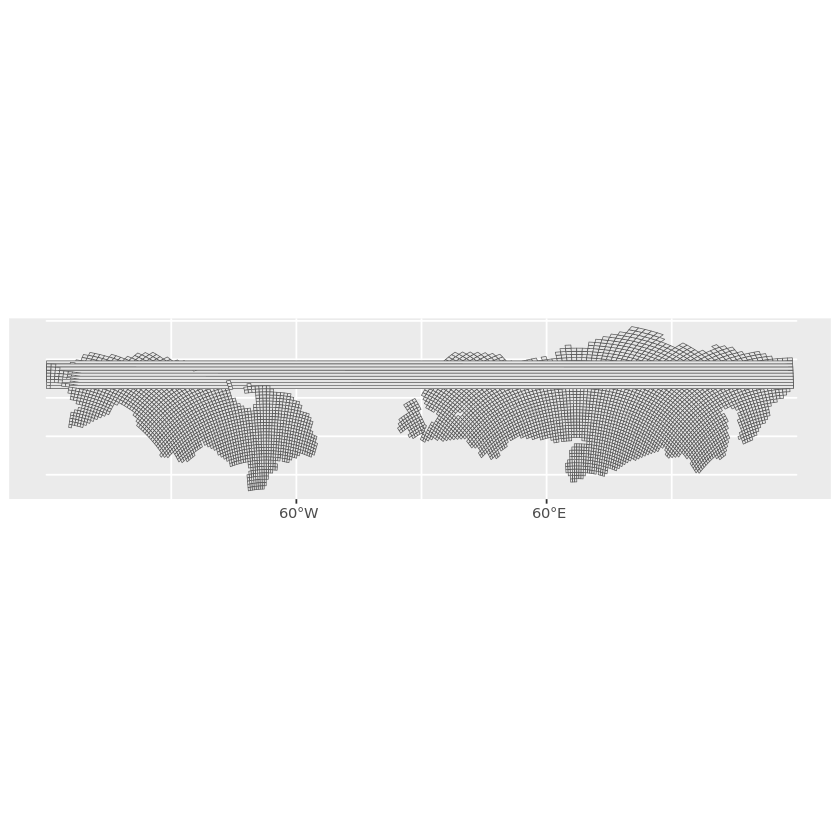

In [25]:
ggplot(boreal_tiles) + geom_sf()

In [26]:
if(CLIP_TO_A_DOMAIN){
    DOMAIN_STR = 'boreal_clip'
    if(REALM_STR == 'circumboreal'){
        DOMAIN_INTERSECTION_EXTENT = boreal
        files_domain = files_boreal
    }else{
        DOMAIN_INTERSECTION_EXTENT = boreal %>% dplyr::select(REALM)
        if(REALM_STR == 'NA'){files_domain = files_boreal_NA}else{files_domain = files_boreal_PA}
    }
}else{
    DOMAIN_STR = 'all_filt'
    REALM_STR = ''
    DOMAIN_INTERSECTION_EXTENT = boreal_tiles
    files_domain = files_allATL08
    }
    
atl08_feather_fn =    paste0(OUTDIR,'/tables/atl08_agb_',DOMAIN_STR,'_',REALM_STR,'_',nowdate,'.feather')
atl08_flatgeobuf_fn = paste0(OUTDIR,'/tables/atl08_agb_',DOMAIN_STR,'_',REALM_STR,'_',nowdate,'.fgb')
atl08_gpkg_fn =       paste0(OUTDIR,'/tables/atl08_agb_',DOMAIN_STR,'_',REALM_STR,'_',nowdate,'.gpkg')

atl08_gpkg_fn

[1] "/projects/my-public-bucket/boreal_ATL08_AGB/tables/atl08_agb_all_filt__20231122.gpkg"

In [27]:
TEST = FALSE

In [28]:
if(TEST){
    atl08_test = st_intersection(st_as_sf(
                                    do.call(rbind, lapply(
                                                        head(files_domain, 2)$s3_path, #<-- for testing
                                                        function(x) s3read_and_get_tilenum(x)
                                                        )
                                           ) %>% dplyr::select(ATL08_cols_list),
                                    coords = c('lon', 'lat') , remove = FALSE, crs = crs_wgs84
                                    ), 
                            DOMAIN_INTERSECTION_EXTENT
                            ) %>%
                            as.data.frame() %>%
                            dplyr::rename_at(vars(c(ATL08_cols_list), 'REALM'), ~ ATL08_NAMES_FOR_RDS)
                            #dplyr::select(ATL08_cols_list, REALM)
    # Calculate AGB_mean and AGB_se for each ATL08 obs
    #names(atl08_test) = ATL08_NAMES_FOR_RDS
    #atl08_test = GEDI2AT08AGB_v2(models_list, models_id_list, atl08_test , COLS_LIST = ATL08_NAMES_FOR_RDS, RESAMP_COVAR_MAT=TRUE, RESAMP_ITER=2)

    atl08_test$seg_landcov = factor(atl08_test$seg_landcov, levels=class_values , labels=class_names)
    #st_write(atl08_test, atl08_flatgeobuf_fn, driver='FlatGeoBuf') 
    tail(atl08_test)
    }

## Return the data frame of ATL08 AGB obs  
columns: 
`tile_num, seg_landcov, lon, lat, RH_25, RH_50, RH_60, RH_70, RH_75, RH_802, RH_90, RH_98, REALM, DOY, YEAR, AGB_model_id, AGB_mean_mg_ha, AGB_se_mg_ha`  

Resampling covariance matrix `50` times

In [29]:
print(paste0('Realm: ',REALM_STR))
print(paste0('Domain: ',DOMAIN_STR))
nrow(files_domain)

[1] "Realm: "
[1] "Domain: all_filt"


[1] 4880

In [ ]:
if(TRUE){
    print(paste0('Realm: ',REALM_STR))

#     atl08 = do.call(rbind, lapply(
#                 files_boreal$s3_path, 
#                 #head(files_boreal, 100)$s3_path), #<-- for testing
#                 function(x) s3read_and_get_tilenum(x)
#                 )) %>% dplyr::select(ATL08_cols_list)
    
    atl08 = st_intersection(st_as_sf(
                                do.call(rbind, lapply(
                                    #files_domain$s3_path, 
                                    head(files_domain, 5)$s3_path, #<-- for testing
                                    #files_boreal[which(files_boreal$tile_num ==1920),]$s3_path,
                                    function(x) s3read_and_get_tilenum(x)
                                        )
                                       ) %>% dplyr::select(all_of(ATL08_cols_list)),
                                coords = c('lon', 'lat') , 
                                remove = FALSE,
                                crs = crs_wgs84
                                #crs = st_crs(4326) # NSIDC QA update
                                    ), 
                        DOMAIN_INTERSECTION_EXTENT
                        ) %>%
                        dplyr::rename_at(vars(c(ATL08_cols_list), 'REALM'), ~ ATL08_NAMES_FOR_RDS) #%>%
                        #dplyr::select(ATL08_cols_list, REALM)
    #
    # Calculate AGB_mean and AGB_se for each ATL08 obs    
    #
    atl08 = GEDI2AT08AGB_v2(models_list, models_id_list, atl08 , COLS_LIST = ATL08_NAMES_FOR_RDS, RESAMP_COVAR_MAT=TRUE, RESAMP_ITER=50)
    
    # Return as sf :  GEDI2AT08AGB_v2() removes geometry...
    atl08 = st_as_sf(atl08, coords = c('lon', 'lat') , remove = FALSE, crs = crs_wgs84)
    
    # Clean land cover class names
    atl08$seg_landcov = factor(atl08$seg_landcov, levels=class_values , labels=class_names)
    
    # Write file
    #st_write(atl08, atl08_flatgeobuf_fn, driver='FlatGeoBuf') 
    st_write(atl08, atl08_gpkg_fn)
    
    # Write a new feather dataset of boreal-filtered ATL08 RH metrics, AGB_mean, & AGB_se for all boreal tiles 
    #write_feather(atl08, path = atl08_feather_fn)
    
}else{
    #atl08 = read_feather(atl08_feather_fn)
    #atl08 = st_read(atl08_flatgeobuf_fn)
    atl08 = st_read(atl08_gpkg_fn)
}
#print(paste0('Total filtered ATL08 obs for ', dim(files_boreal)[1],' tiles of boreal domain: ', dim(atl08)[1]))
print(paste0('Total filtered ATL08 obs for with AGB in boreal domain: ', dim(atl08)[1]))

head(atl08%>% as.data.frame() )

In [ ]:
ggplot(atl08) + geom_histogram(aes(DOY))

In [ ]:
ggplot(sample_frac(atl08, size=0.0001)) + geom_sf(aes(color=AGB_mean_mg_ha)) + scale_color_viridis()

In [71]:
rm(atl08)